In [2]:
import pandas as pd
import torch.nn as nn
import random
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
points = pd.read_csv("rotated_points_angle.csv")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_nodes = 5
        self.ff = nn.Sequential(
            nn.Linear(1, hidden_nodes),
            nn.Sigmoid(),
            nn.Linear(hidden_nodes, 1),
        )
    
    def forward(self, x_batch):
        return self.ff(x_batch)

## Check if model can learn sine function

In [5]:
random.seed(234)
model = Net()
opt = Adam(model.parameters())

In [6]:
model.train()
for i in tqdm(range(300000)):
    alpha = random.uniform(0, 2*math.pi)
    pred = model(torch.Tensor([alpha]))
    y_true = math.sin(alpha)
    opt.zero_grad()
    loss = (pred - y_true) ** 2
    loss.backward()
    opt.step()

In [7]:
test = np.linspace(0, 2*math.pi, 100)

In [8]:
model.eval()
pred = model(torch.Tensor(np.matrix(test).transpose()))

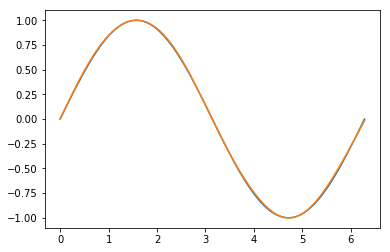

In [9]:
plt.plot(test, np.sin(test))
plt.plot(test, pred.detach().numpy())
plt.show()

# Train nets for matrix

In [52]:
def get_loader(data):
    X = torch.FloatTensor(data[["x1", "y1", "alpha"]].values)
    y = torch.FloatTensor(data[["x2", "y2"]].values)
    torch_data = TensorDataset(X, y)
    loader = DataLoader(torch_data, shuffle=False)
    return loader

In [53]:
n_points_val = 10
val_loader = get_loader(points.tail(n_points_val))

In [54]:
def calc_loss(x_batch, y_batch, nets):
    alphas = x_batch[:, [2]]
    matrix_entries = [model(alphas) for model in nets]
    loss = 0
    for i in range(len(alphas)):
        predx = matrix_entries[0][i] * x_batch[i][0] + matrix_entries[1][i] * x_batch[i][1]
        predy = matrix_entries[2][i] * x_batch[i][0] + matrix_entries[3][i] * x_batch[i][1]
        loss += (predx - y_batch[i][0]) ** 2
        loss += (predy - y_batch[i][1]) ** 2
    loss /= len(alphas)
    return loss

Epoch 0: Val 1.0163618326187134, Train 1.2102597951889038
Epoch 1000: Val 0.5955855250358582, Train 0.149177685379982
Epoch 2000: Val 0.20054781436920166, Train 0.05602322146296501
Epoch 3000: Val 0.14283835887908936, Train 0.03274773061275482
Epoch 4000: Val 0.13351301848888397, Train 0.023697035387158394


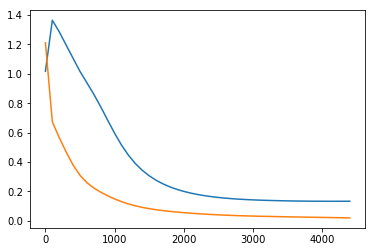

CPU times: user 1min 1s, sys: 1.01 s, total: 1min 2s
Wall time: 1min 2s


In [60]:
%%time
nets = [Net() for _ in range(4)]
opts = [Adam(model.parameters()) for model in nets]
n_points = 10
train_loader = get_loader(points.head(n_points))
losses = []
train_losses = []
epochs = []
epoch = 0
epochs_per_validation = 100
while True:
    # training
    for model in nets:
        model.train()
    for x_batch, y_batch in train_loader:
        loss = calc_loss(x_batch, y_batch, nets)
        for opt in opts:
            opt.zero_grad()
        loss.backward()
        for opt in opts:
            opt.step()
    # validation
    if epoch % epochs_per_validation == 0:
        for model in nets:
            model.eval()
        val_loss = 0
        train_loss = 0
        for x_batch, y_batch in val_loader:
            val_loss += calc_loss(x_batch, y_batch, nets)
        for x_batch, y_batch in train_loader:
            train_loss += calc_loss(x_batch, y_batch, nets)
        val_loss /= n_points_val
        train_loss /= n_points
        losses.append(val_loss.item())
        train_losses.append(train_loss.item())
        epochs.append(epoch)
        if epoch % 1000 == 0:
            print("Epoch {}: Val {}, Train {}".format(epoch, losses[-1], train_losses[-1]))
        reference_loss_index = 500//epochs_per_validation
        if epoch > 1000 and len(losses) > reference_loss_index and losses[-1] > losses[-reference_loss_index]:
            break
    epoch += 1
plt.plot(epochs, losses)
plt.plot(epochs, train_losses)
plt.show()

In [61]:
import os
os.system('say "your program has finished"')

0

In [62]:
import RotationMatrix
n_test = 16
test = []
for alpha in np.linspace(0, 2*math.pi, n_test)[:-1]:
    x1, y1 = RotationMatrix.apply_rotation(1, 0, alpha)
    x2, y2 = RotationMatrix.apply_rotation(x1, y1, alpha)
    test.append([alpha, x1, y1, x2, y2])
test = pd.DataFrame(test, columns=['alpha', 'x1', 'y1', 'x2', 'y2'])
test_loader = get_loader(test)

In [63]:
test_loss = 0
for x_batch, y_batch in test_loader:
    test_loss += calc_loss(x_batch, y_batch, nets)
test_loss /= n_test

In [64]:
test_loss

tensor([1.6518], grad_fn=<DivBackward0>)